# Solve *Easy21* by Deep Q-Network


In [40]:
import itertools
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

sns.set()
%matplotlib inline

In [4]:
from plot_utils import draw_heatmap
from dp_tools import mean_policy_value
from easy21 import Easy21, HIT, STICK

env = Easy21()

## Deep Q-network with experience replay and target network

1. Initialize Q-function $Q(s, a; \theta)$. Initialize replay buffer. Initialize the target Q-function $Q\left(s, a; \tilde{\theta}\right)$ with $\tilde{\theta} = \theta$ as a copy of the Q-function.
1. Set $t=0$ and initialize $s_t$
1. Choose action $a_t$ from exploration policy with the current $Q$ function.
1. Take $a_t$ and observe $(s_{t+1}, r_{t+1})$.
1. Push $(s_t, a_t, r_{t+1}, s_{t+1})$ to the replay buffer.
1. Extract a batch of $(s_i, a_i, r_i, s_i')$ from the replay buffer.
1. For each batch sample, compute the TD target as $v_i \leftarrow r_i + \gamma Q\left(s'_i, a'_i, \tilde{\theta} \right)$, where $a'_i = \mathrm{arg}\max_a Q(s'_i, a; \theta)$.
1. For each batch sample, compute the TD error as $\delta_i \leftarrow v_i - Q(s_i, a_i; \theta)$.
1. Update $\theta$ by:
$$
\theta \leftarrow \theta + \alpha \frac{\sum_{i=1}^{n} \delta_i}{n} \; \nabla Q(s, a; \theta),
$$
where $n$ is the batch size.
1. If step count matches the target update cycle, set $\tilde{\theta} \leftarrow \theta$.
1. If $s_{t+1}$ is terminal, then go to 2.
1. If maximum iteration has been reached, finish.  Otherwise set $t \leftarrow t+1$ and go to 3.

## Scratch implementation with pytorch

### Q-function and target Q-function

In [8]:
class QNetwork(nn.Module):
    def __init__(self, hidden_size=10):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 2)
    
    def forward(self, s):
        """
        Returns tensor of q values.
        s must be a Variable of shape (samples, 2)
        """
        x = F.relu(self.fc1(s))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [131]:
qnet = QNetwork()
tnet = QNetwork()
tnet.load_state_dict(qnet.state_dict())

### Replay buffer

In [30]:
class ReplayBuffer:
    def __init__(self, size):
        assert isinstance(size, int) and size > 0, "size must be positive integer"
        self.size = size
        self._storage = np.empty(size, dtype=object)
        self._i = 0
        self._filled = False

    def push(self, x):
        self._storage[self._i] = x
        self._i = (self._i + 1) % self.size
        if self._i == 0:
            self._filled = True
    
    def sample(self, batch_size):
        if self._filled:
            return np.random.choice(self._storage, batch_size, replace=True)
        else:
            return np.random.choice(self._storage[0:self._i], batch_size, replace=True)

In [31]:
# test
replay_memory = ReplayBuffer(10**4)
replay_memory.push(1)
replay_memory.sample(5)

array([1, 1, 1, 1, 1], dtype=object)

In [32]:
replay_memory = ReplayBuffer(10**4)
replay_memory.push(1)
replay_memory.push((2, 3))
replay_memory.sample(10)

array([1, 1, (2, 3), 1, (2, 3), (2, 3), 1, (2, 3), (2, 3), 1],
      dtype=object)

In [36]:
replay_memory = ReplayBuffer(3)
replay_memory.push(1)
replay_memory.push(2)
replay_memory.push(3)
replay_memory.push(4)
replay_memory.push(5)
replay_memory.sample(10)

array([5, 3, 3, 5, 3, 5, 4, 4, 3, 4], dtype=object)

### Explore policy

In [38]:
def EpsilonGreedyPolicy(epsilon):
    def epsilon_greedy_policy(qvalues):
        if random.random() < epsilon:
            return random.randint(0, len(qvalues)-1)
        else:
            return np.argmax(qvalues)
    return epsilon_greedy_policy

explore_policy = EpsilonGreedyPolicy(0.05)

### Convert states to tensor

In [196]:
def states_to_tensor(states):
    # normalize so the max is 1.0
    states = np.asarray(states) / np.array([21., 11.])
    return Variable(torch.FloatTensor(states))

### Single episode run for the DQN

In [302]:
def dqn_episode(qnet, tnet, optimizer, replay_memory, explore_policy, 
                step_count=0, sync_cycle=100, gamma=1.0, batch_size=128):
    s = env.reset()
    losses = []
    while True:
        s_ = states_to_tensor([s])
        qvalues = qnet(s_)
        a = explore_policy(qvalues.detach().numpy()[0])
        s1, r, done, _ = env.step(a)
        replay_memory.push((s, a, r, s1, done))
        
        
        data = replay_memory.sample(batch_size)
        states, actions, rewards, states2, dones = zip(*data)
        # convert data into tensor variables
        states_ = states_to_tensor(states)
        actions_ = Variable(torch.LongTensor(np.asarray(actions)))
        rewards_ = Variable(torch.FloatTensor(np.asarray(rewards)))
        dones_ = Variable(torch.FloatTensor(np.asarray(dones, dtype=float)))
        states2_ = states_to_tensor(states2)
        # compute target
        _, actions2_ = qnet(states2_).max(dim=-1)
        tgt = rewards_ + gamma * tnet(states2_)[range(batch_size), actions2_] * (1 - dones_)
        tgt = tgt.detach()  # do not calculate gradient for target
        # compute prediction
        pred = qnet(states_)[range(batch_size), actions_]
        # compute loss, and then update weights
        loss = torch.mean((tgt - pred) ** 2)
        losses.append(loss.data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # check the step count and update target weights if needed
        step_count += 1
        if step_count % sync_cycle == 0:
            tnet.load_state_dict(qnet.state_dict())
        
        if done:
            break
        else:
            s = s1
    return qnet, tnet, step_count, losses
        

In [303]:
# test run
qnet = QNetwork()
tnet = QNetwork()
tnet.load_state_dict(qnet.state_dict())
replay_memory = ReplayBuffer(10**4)
optimizer = torch.optim.Adam(qnet.parameters(), lr=0.001)
step_count = 0
losses = []
for i in range(2000):
    qnet, tnet, step_count, losses_ = dqn_episode(qnet, tnet, optimizer, replay_memory, explore_policy, 
                                                  step_count=step_count, sync_cycle=5, batch_size=5)
    losses += losses_

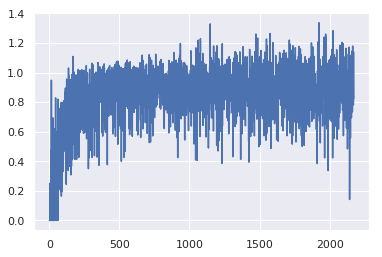

In [304]:
plt.plot(losses)

In [305]:
replay_memory.sample(3)

array([((4, 2), 0, 1.0, (4, 0), True), ((2, 3), 0, 1.0, (2, 0), True),
       ((9, 7), 0, -1.0, (9, 17), True)], dtype=object)

In [306]:
def to_q_array(qnet):
    states = np.empty((21, 10, 2))
    for p in range(21): states[p, :, 0] = p+1
    for d in range(10): states[:, d, 1] = d+1
    states = states.reshape((-1, 2))
    states_ = states_to_tensor(states)
    qs = qnet(states_).data.numpy().reshape(21, 10, 2)
    return qs

In [307]:
# load DP solution for model evaluation
f = np.load("result/dp.npz")
V_dp = f["V"]
Q_dp = f["Q"]
policy_dp = f["pi"]
mean_value_dp = f["mean_value"]
print(V_dp.shape, Q_dp.shape, policy_dp.shape)

def evaluate_qnet(qnet, plot=True, message=True):
    q_array = to_q_array(qnet)
    
    V = np.max(q_array, axis=-1)
    q_diff = q_array[:,:,1] - q_array[:,:,0]
    policy = np.argmax(q_array, axis=-1)

    if plot:
        # visualization
        fig, ax = plt.subplots(figsize=(6, 6))
        draw_heatmap(V, ax=ax, title="State Value")
        fig.tight_layout()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharex=True, sharey=True)
        draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
        draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
        fig.tight_layout()
    else:
        fig = None
    # mae of state values
    mae_v = np.mean(np.abs(V - V_dp))
    # mae of q values
    mae_q = np.mean(np.abs(q_array - Q_dp))
    # fraction of policy matched with the DP result
    frac = np.mean(policy == policy_dp)
    # mean policy value
    mean_value = mean_policy_value(policy, gamma=1.0)
    if message:
        print("MAE of state values      = %.5f" % (mae_v))
        print("MAE of action values     = %.5f" % (mae_q))
        print("Fraction of policy match = %.2f%%" % (100*frac))
        print("Expected player value    = %.5f" % (mean_value))
    return mae_v, mae_q, frac, mean_value, fig


(21, 10) (21, 10, 2) (21, 10)


MAE of state values      = 0.22697
MAE of action values     = 0.19394
Fraction of policy match = 72.86%
Expected player value    = 0.04493


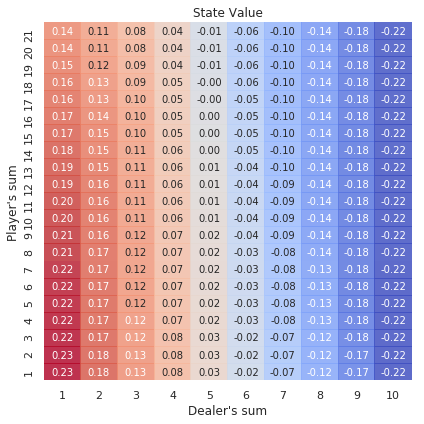

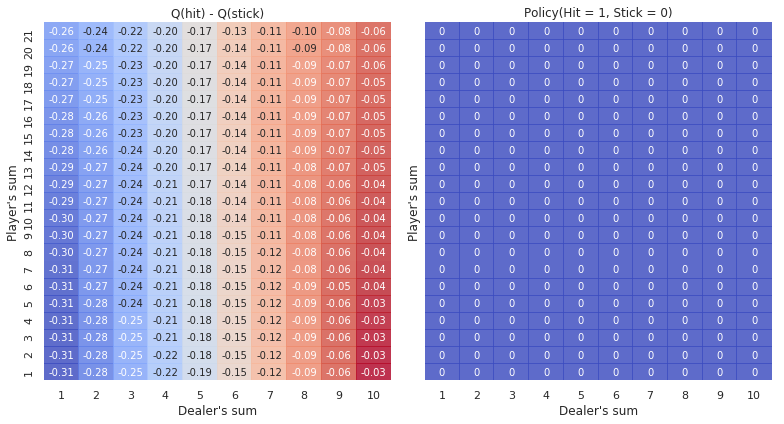

In [308]:
evaluate_qnet(qnet)
None

### Run the algorithm

We set $\epsilon$ to relatively high level (0.5). This is because we want to observe more variety of state-action pairs.  Notice that there is not much disadvantage of doing so in this game, since we can collect all state-action pairs even with a complete random plays.  This is not the case for problems like maze or cliff walk, where you need to choose near-optimal actions in order to experience all states.

In [333]:
qnet = QNetwork(hidden_size=8)
tnet = QNetwork(hidden_size=8)
tnet.load_state_dict(qnet.state_dict())
explore_policy = EpsilonGreedyPolicy(0.5)
replay_memory = ReplayBuffer(10**4)
optimizer = torch.optim.Adam(qnet.parameters(), lr=1e-4)
step_count = 0
mae_vs = []
mae_qs = []
fracs = []
values = []
losses = []

In [334]:
for i in range(10**5):
    qnet, tnet, step_count, losses_ = dqn_episode(qnet, tnet, optimizer, replay_memory, explore_policy, 
                                                  step_count=step_count, sync_cycle=100, batch_size=128)
    losses += losses_
    if (i+1) % 100 == 0:
        mae_v, mae_q, frac, value_, _ = evaluate_qnet(qnet, plot=False, message=False)
        mae_vs.append(mae_v)
        mae_qs.append(mae_q)
        fracs.append(frac)
        values.append(value_)
        if (i+1) % 2500 == 0:
            clear_output()
            print("Iter #%d" % (i+1))
            print("  MAE of state values             = %.4f" % mae_v)
            print("  MAE of state-action values      = %.4f" % mae_q)
            print("  Player mean value               = %.4f" % value_)
            print("  Fraction of policy match        = %.2f%%" % (100*frac))
            print("  Average of last 100 loss        = %.4f" % (sum(losses[-100:]) / 100.))

Iter #100000
  MAE of state values             = 0.0866
  MAE of state-action values      = 0.0663
  Player mean value               = 0.0599
  Fraction of policy match        = 91.90%
  Average of last 100 loss        = 0.6247


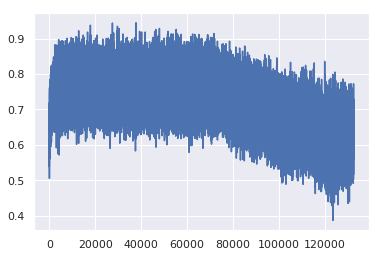

In [340]:
# losses at the initial phase is not meaningful, since the target is completely wrong.
# The target is never be "correct" in reinforcement learning; They get better along the iterations, hopefully.
plt.plot(losses[500:])

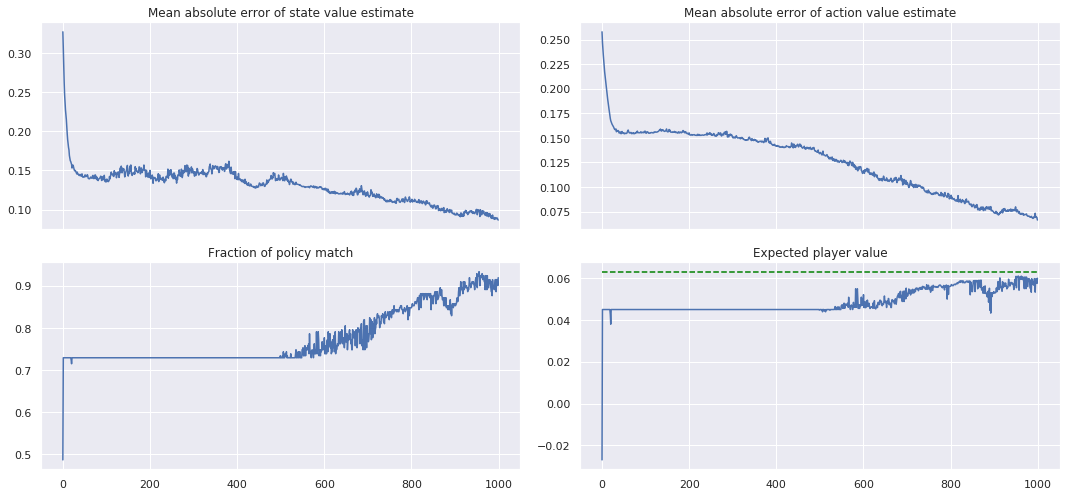

In [336]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
axes[0][0].plot(mae_vs)
axes[0][1].plot(mae_qs)
axes[1][0].plot(fracs)
axes[1][1].plot(values)
axes[1][1].hlines(mean_value_dp, 0, len(values), linestyles="--", color="green")
axes[0][0].set_title("Mean absolute error of state value estimate")
axes[0][1].set_title("Mean absolute error of action value estimate")
axes[1][0].set_title("Fraction of policy match")
axes[1][1].set_title("Expected player value")
fig.tight_layout()
None

MAE of state values      = 0.08659
MAE of action values     = 0.06634
Fraction of policy match = 91.90%
Expected player value    = 0.05989


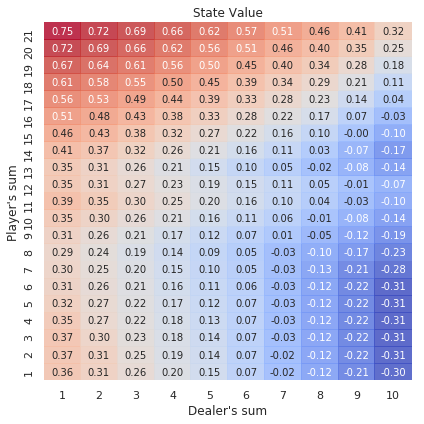

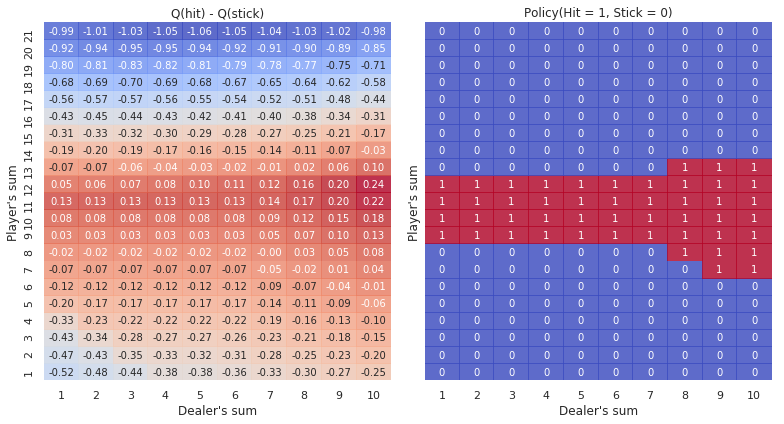

In [337]:
evaluate_qnet(qnet)
None

*Remark: We obtained result close to the tabular Q-learning.*

## Implementation using keras-rl